In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sklearn
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [14]:
data = pd.read_csv('/content/drive/MyDrive/College/PS - 1/Notebooks/manuscript/models/comparison/unnormalized.csv')
data.drop(columns=['Unnamed: 0'], inplace = True)
data

,Age,Gender,BMI,Symptoms Present?,Fever,Cough,Breathlessness,Travel History,Temp,SPO2,Contact to NCOVID Patient,Co-morbidity?,Diabetes,Hypertension,Heart Condition,Respiratory rate(breaths per minute),Outcome,qSOFA SCORE,HEMOGLOBIN,TLC COUNT,PLATELET COUNT,RANDOM BLOOD SUGAR,UREA,CREATININE,SODIUM,POTASSIUM,CHLORIDE,TOTAL BILIRUBIN,DIRECT BILIRUBIN,SGOT,SGPT,TOTAL PROTEINS,ALBUMIN,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS
0,53,1,22.5,1,1,1,1,0,96.8,99.0,1,0,0,0,0,20.0,0.0,0.0,15.9,6200.0,127000.0,121.0,47.5,1.3,143.0,4.8,108.0,0.5,0.2,81.3,70.0,5.9,3.8,44.1,58.10
1,26,0,25.7,0,0,0,0,0,98.7,98.0,1,0,0,0,0,16.0,0.0,0.0,13.4,4140.0,188000.0,96.0,21.8,1.0,148.0,4.1,108.0,0.3,0.1,22.2,14.8,6.6,3.9,58.5,3.66
2,28,1,22.2,0,0,0,0,0,98.4,98.0,1,0,0,0,0,16.0,0.0,0.0,15.9,4680.0,231000.0,102.0,18.3,5800.0,159.0,18.1,1.1,0.8,0.3,19.3,12.8,7.0,4.2,86.0,10.17
3,73,1,21.5,1,1,1,1,0,98.0,98.0,1,0,0,0,0,26.0,1.0,1.0,13.2,5200.0,234000.0,119.0,36.6,0.9,140.0,4.2,104.0,2.4,1.2,59.0,47.9,6.3,3.7,120.0,168.90
4,49,1,27.4,1,1,1,0,0,101.0,98.0,1,1,0,0,0,20.0,0.0,0.0,13.7,9500.0,321000.0,92.0,22.0,0.9,124.0,3.8,92.0,4.2,2.1,44.6,55.5,5.9,3.1,177.0,164.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,53,1,27.2,1,1,1,1,0,98.9,96.0,1,1,1,1,0,28.0,1.0,1.0,18.2,6700.0,101000.0,200.0,54.1,0.9,136.0,2.9,97.0,1.4,0.5,43.8,38.8,6.2,3.7,73.3,127.60
171,33,1,26.0,1,1,1,1,0,99.3,98.0,1,1,1,0,0,28.0,1.0,1.0,13.9,6800.0,156000.0,151.0,59.6,1.9,141.0,4.2,106.0,0.5,0.2,80.6,42.6,6.6,3.8,57.4,138.15
172,70,1,21.4,1,1,0,1,0,98.3,99.0,0,1,0,0,0,20.0,1.0,0.0,14.9,8900.0,1820000.0,189.0,25.2,1.1,137.0,4.2,106.0,1.8,0.6,77.0,27.9,5.9,3.3,60.1,143.00
173,65,0,22.4,1,0,1,1,0,98.9,97.0,0,1,1,1,0,32.0,1.0,1.0,11.2,12000.0,124000.0,210.0,43.2,1.3,132.0,3.8,110.0,1.2,0.6,56.2,43.2,5.6,3.4,216.0,124.00


In [15]:
# data.drop(['qSOFA SCORE'],inplace=True)
X= data.drop(['Outcome','qSOFA SCORE'],axis=1)
Y = data['Outcome']

In [16]:
def nestedcv(pipeline,param_grid, X, Y):
    
    
    f1 = [0]*7
    roc = [0]*7
    prec = [0]*7
    rec = [0]*7
    acc = [0]*7
    
    
    cv_outer = KFold(n_splits=7, random_state=1, shuffle=True)
    i = 0
    
    for train_ix, test_ix in cv_outer.split(X):
        
        X_train = X.iloc[train_ix]
        X_test =  X.iloc[test_ix]
        y_train = Y.iloc[train_ix]
        y_test =  Y.iloc[test_ix]
        scaler = MinMaxScaler()
        
        model = ExtraTreesClassifier()
        model.fit(scaler.fit_transform(X_train),y_train)

        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
        x = feat_importances.nlargest(5)
        features = np.array(x.index)
        print(features)

        gs = GridSearchCV(estimator=pipeline, param_grid = param_grid,
                     cv = 6, scoring = 'f1', n_jobs = -1, refit = True)
        
        result = gs.fit(X_train[features],y_train)
        print(result.best_params_)
        best_model = result.best_estimator_
        
        y_hat = best_model.predict(X_test[features])
        f1[i] = metrics.f1_score(y_test, y_hat)
        roc[i] = metrics.roc_auc_score(y_test, y_hat)
        prec[i] = metrics.precision_score(y_test, y_hat)
        rec[i] = metrics.recall_score(y_test,y_hat)
        acc[i] = metrics.accuracy_score(y_test,y_hat)
        i+=1
        print(i)
        if i==6:
          pred_prob1 = model.predict_proba(X_test)
          fpr, tpr, thresh = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
          random_probs = [0 for i in range(len(y_test))]
          p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
          cf_matrix = confusion_matrix(y_test, y_hat)
         
    arr = [np.mean(acc),np.mean(f1),np.mean(roc),np.mean(prec),np.mean(rec)]
    return arr, fpr, tpr, p_fpr, p_tpr, cf_matrix

In [17]:
# Pipeline created using Logistic Regression
pipeline = make_pipeline(MinMaxScaler(),LogisticRegression(max_iter=10000))

param_grid = {'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
'logisticregression__penalty' : ['l2'],
'logisticregression__C' : [300, 100, 30, 10, 3, 1.0, 0.3, 0.1, 0.03, 0.01]} 

lg, fpr_lr, tpr_lr, p_fpr, p_tpr, cf_lr = nestedcv(pipeline,param_grid,X,Y)
lg

['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
1
['Respiratory rate(breaths per minute)' 'Breathlessness'
 'C-REACTIVE PROTEINS' 'Age' 'TLC COUNT']
{'logisticregression__C': 300, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
2
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'UREA']
{'logisticregression__C': 30, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
3
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'logisticregression__C': 30, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
4
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'TLC COUNT' 'Age']
{'logisticregression__C': 300, 'logisticregression__penalty'

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.9199999999999999,
 0.600453514739229,
 0.7767221908526257,
 0.6571428571428571,
 0.5928571428571427]

In [18]:
# Pipeline created using Logistic Regression
pipeline = make_pipeline(MinMaxScaler(),
                         RandomForestClassifier())
#
# Create the parameter grid
#

param_grid = {
    'randomforestclassifier__n_estimators': [400, 700],
    'randomforestclassifier__max_depth': [15,20],
    'randomforestclassifier__max_leaf_nodes': [50, 100]
}

rf, fpr_rf, tpr_rf, p_fpr, p_tpr, cf_rf = nestedcv(pipeline,param_grid,X,Y)
rf

['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'TLC COUNT' 'Age']
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 100, 'randomforestclassifier__n_estimators': 700}
1
['Respiratory rate(breaths per minute)' 'Breathlessness'
 'C-REACTIVE PROTEINS' 'Age' 'TLC COUNT']
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 100, 'randomforestclassifier__n_estimators': 400}
2
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'UREA' 'Age']
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 100, 'randomforestclassifier__n_estimators': 400}
3
['C-REACTIVE PROTEINS' 'Respiratory rate(breaths per minute)'
 'Breathlessness' 'Age' 'TLC COUNT']
{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_leaf_nodes': 50, 'randomforestclassifier__n_estimators': 700}
4
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Br

[0.9542857142857143,
 0.7976190476190476,
 0.8698381328816112,
 0.8809523809523808,
 0.7523809523809524]

In [19]:
# Pipeline created using Logistic Regression
pipeline = make_pipeline(MinMaxScaler(),
                         MLPClassifier(max_iter=3000))
#
# Create the parameter grid
#
pipeline.get_params().keys()
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,)],
    'mlpclassifier__activation': ['relu','logistic'],
    'mlpclassifier__solver': ['lbfgs'],
    'mlpclassifier__alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'mlpclassifier__learning_rate': ['constant','adaptive'],
}

mlp, fpr_mlp, tpr_mlp, p_fpr, p_tpr, cf_mlp = nestedcv(pipeline,param_grid,X,Y)
mlp

['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.03, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'lbfgs'}
1
['Respiratory rate(breaths per minute)' 'Breathlessness'
 'C-REACTIVE PROTEINS' 'Age' 'TLC COUNT']
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (50,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__solver': 'lbfgs'}
2
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__solver': 'lbfgs'}
3
['C-REACTIVE PROTEINS' 'Respiratory rate(breaths per minute)'
 'Breathlessness' 'TLC COUNT' 'ALBUMIN']
{'mlpclassifier__activa

[0.9428571428571428,
 0.7444444444444445,
 0.8631359065365277,
 0.7999999999999999,
 0.7523809523809524]

In [20]:
# Pipeline created using Logistic Regression
pipeline = make_pipeline(MinMaxScaler(),
                         XGBClassifier())
#
# Create the parameter grid
#
# pipeline.get_params().keys()

param_grid = {
    'xgbclassifier__n_estimators': [400, 700],
    'xgbclassifier__colsample_bytree': [0.7, 0.8],
    'xgbclassifier__max_depth': [15,20],
    'xgbclassifier__reg_alpha': [1.1, 1.2],
    'xgbclassifier__reg_lambda': [1.1, 1.2],
    'xgbclassifier__subsample': [0.7, 0.8]
}
xgb, fpr_xgb, tpr_xgb, p_fpr, p_tpr, cf_xgb = nestedcv(pipeline,param_grid,X,Y)
xgb

['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.2, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.8}
1
['Respiratory rate(breaths per minute)' 'Breathlessness'
 'C-REACTIVE PROTEINS' 'Age' 'TLC COUNT']
{'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 700, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.8}
2
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'UREA']
{'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__max_depth': 15, 'xgbclassifier__n_estimators': 400, 'xgbclassifier__reg_alpha': 1.1, 'xgbclassifier__reg_lambda': 1.1, 'xgbclassifier__subsample': 0.8}
3
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessn

[0.9542857142857143,
 0.7976190476190476,
 0.8698381328816112,
 0.8809523809523808,
 0.7523809523809524]

In [21]:
svm = SVC()
pipeline = make_pipeline(MinMaxScaler(),
                         SVC())
#
# Create the parameter grid
#
param_grid = {'svc__C': [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], 
              'svc__gamma': [3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001],
              'svc__kernel': ['rbf','linear','sigmoid','poly']} 


svc, fpr_svc, tpr_svc, p_fpr, p_tpr, cf_svc = nestedcv(pipeline,param_grid,X,Y)
svc


['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'SGOT']
{'svc__C': 10, 'svc__gamma': 0.3, 'svc__kernel': 'rbf'}
1
['Respiratory rate(breaths per minute)' 'Breathlessness'
 'C-REACTIVE PROTEINS' 'Age' 'TLC COUNT']
{'svc__C': 30, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
2
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'ALKALINE PHOSPHATASE']
{'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'poly'}
3
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'Age' 'TLC COUNT']
{'svc__C': 30, 'svc__gamma': 3, 'svc__kernel': 'poly'}
4
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'TLC COUNT' 'Age']
{'svc__C': 3, 'svc__gamma': 3, 'svc__kernel': 'rbf'}
5
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEINS'
 'Breathlessness' 'TLC COUNT' 'Age']
{'svc__C': 3, 'svc__gamma': 3, 'svc__kernel': 'rbf'}
6
['Respiratory rate(breaths per minute)' 'C-REACTIVE PROTEIN

[0.9428571428571428,
 0.7555555555555555,
 0.8533126293995859,
 0.8639455782312925,
 0.7333333333333334]

In [22]:
headings = ['Model','Accuracy Score','Precision Score','Recall Score','F1 Score','ROC-AUC']
data = [['Logistic Regression',0.926, 0.678, 0.593, 0.610,0.780], ['Random Forest',0.96,0.928,
 0.752,
 0.817,
 0.873
 ], ['Support Vector Machine',
0.931,
                                                                                       0.787,
 0.662,
 0.683,
 0.814,
 ],['XGBoost', 0.937,
    0.824,
 0.724,
 0.753,
 0.849,
 ],['Multi-Layer Perception',0.960,
                 0.876,
 0.828,
 0.836,
 0.904,
 ]]
df = pd.DataFrame(data, columns = headings)
df

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC-AUC
0,Logistic Regression,0.926,0.678,0.593,0.610,0.780
1,Random Forest,0.960,0.928,0.752,0.817,0.873
2,Support Vector Machine,0.931,0.787,0.662,0.683,0.814
3,XGBoost,0.937,0.824,0.724,0.753,0.849
4,Multi-Layer Perception,0.960,0.876,0.828,0.836,0.904


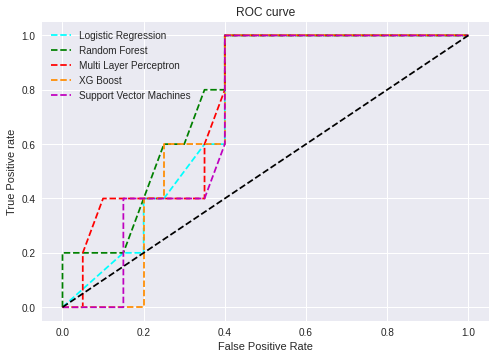

In [23]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_lr, tpr_lr, linestyle='--',color='cyan', label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, linestyle='--',color='green', label='Random Forest')
plt.plot(fpr_mlp, tpr_mlp, linestyle='--',color='red', label='Multi Layer Perceptron')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='darkorange', label='XG Boost')
plt.plot(fpr_svc, tpr_svc, linestyle='--',color='m', label='Support Vector Machines')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

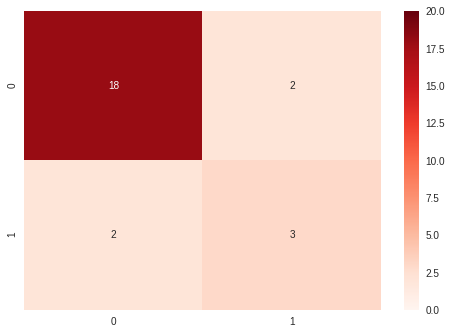

In [24]:
import seaborn as sns
sns.heatmap(cf_lr, cmap="Reds", annot=True, vmin = 0, vmax = 20)

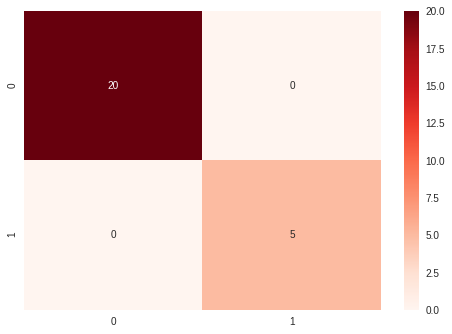

In [25]:
import seaborn as sns
sns.heatmap(cf_xgb, cmap="Reds", annot=True, vmin = 0, vmax = 20)

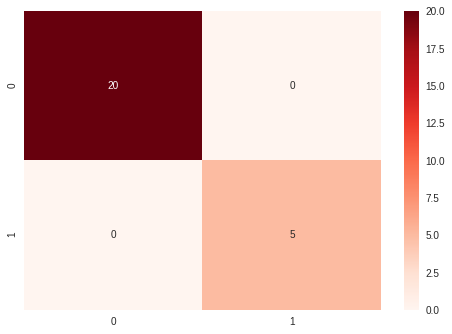

In [26]:
import seaborn as sns
sns.heatmap(cf_rf, cmap="Reds", annot=True, vmin = 0, vmax = 20)

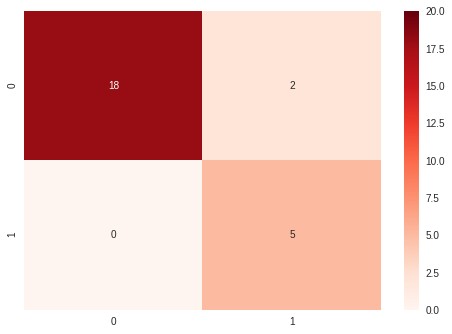

In [27]:
import seaborn as sns
sns.heatmap(cf_svc,cmap="Reds", annot=True, vmin = 0, vmax = 20)

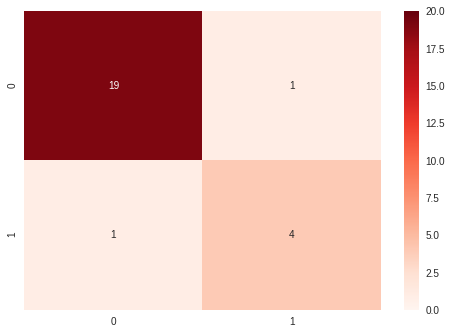

In [28]:
import seaborn as sns
sns.heatmap(cf_mlp,cmap="Reds", annot=True, vmin = 0, vmax = 20)